This notebook calculates the DEM for a set of EIS observations and compares the modeled intensities.
The main purpose of this notebook is to reproduce an issue between the observed and DEM-modeled intensities, as the later tend to be systematically lower. 

It uses the demregpy for the calculation of the DEM.
Also, ChiantiPy and EISPAC for atomic data and the analysis of EIS observations, respectively.

### Data 

The data I am using are EIS observations of a region that includes quite sun and coronal hole plasma. They can be found in the 'Data' folder and I have already done the fitting of the lines I am interested using the EISPAC templates. The fit results can be found in the Data/fit_res folder. 

### DEM 
For the DEM I am using 7 iron lines. 
As a fist test I am focusing only on a single pixel in the EIS field of view.

In [1]:
# Import the necessary libraries/functions
import scipy.io as io
from demregpy import dn2dem
import demregpy
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt

from helper_functions import y_shift_eis_map
from helper_functions import replace_bad_pixels_eis_intmaps as rbps
from helper_functions import get_gofnt_for_eismap
from helper_functions import get_gofnt_for_pixel

##### Load the data

In [2]:
# Lines to be used 
# 1. Fe X 184.54 
# 2. Fe VIII 185.21
# 3. Fe XI 188.22     #also 2c-1
# 4. Fe XII 195.1     #also 2c-1
# 5. Fe IX 197.860 
# 6. Fe XIII 202.040
# 7. FE XV 284.160 

data_dir = './Data'
fit_res_dir = './Data/fit_res'

fit_res_filenames = ['eis_20110525_235841.fe_10_184_536.1c-0.fit.h5',
                     'eis_20110525_235841.fe_08_185_213.1c-0.fit.h5',
                     'eis_20110525_235841.fe_11_188_216.2c-0.fit.h5',
                     'eis_20110525_235841.fe_12_195_119.2c-0.fit.h5',
                     'eis_20110525_235841.fe_09_197_862.1c-0.fit.h5',
                     'eis_20110525_235841.fe_13_202_044.1c-0.fit.h5',
                     'eis_20110525_235841.fe_15_284_160.1c-0.fit.h5',] 

fit_res_list = []
int_maps = [] 

for fname in fit_res_filenames:
    fit_res_filepath = os.path.join(fit_res_dir,fname)
    fit_res = (eispac.read_fit(fit_res_filepath))
    fit_res_list.append(fit_res)
    int_maps.append(fit_res.get_map(0,'int'))

Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_08_185_213.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_11_188_216.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_12_195_119.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_09_197_862.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.fe_13_202_044.1c-0.fit.h5
INFO: uncertainty should have attribute uncertaint

##### Correct for ccd offset in y-direction
(simple approach)

In [3]:
int_maps_new = []
for intmap in int_maps:
    int_maps_new.append(y_shift_eis_map(intmap))    

##### Select a single pixel 

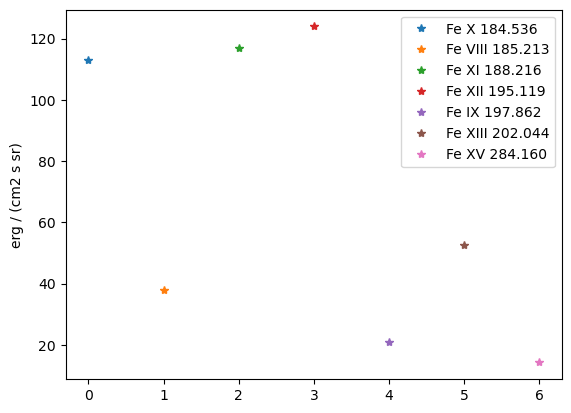

In [4]:
# e.g.:
# QS: x=20,y=30
# CH: x=36, y=208

ix = 20 
iy = 30 

## Get the intensities on that pixel 
int_pix = [] 
for intmap in int_maps_new:
    int_pix.append(intmap.data[iy,ix])

## Make a plot to display these intensities 
fig = plt.figure()
ax = fig.add_subplot()
for i,intpix in enumerate(int_pix):
    ax.plot(i,intpix,'*',label=int_maps_new[i].meta['line_id'])
ax.set_ylabel('%s'%int_maps_new[0].unit)
ax.legend()

##### Get the contribution functions for each line
I need to manually select a density value. For this example I am using 1.e+8.5.
The temperature range I have selected is based on the available lines (i.e. their formation temperatures).

In order to get the contribution functions I am using the 'get_gofnt_for_pixel' function, which for a given intensity map (sunpy.map.Map object) derived from EIS observations can retrieve the corresponding G(n,T) from ChiantiPy.

_!!_ 
This function although it automates in some degree the retrieval of the contributions functions it can return the wrong G(n,T) is some rare cases where the wavelength of the ion in the EIS header is different from the wavelength in Chianti for the same ion. A way to circumvent that issue is to take the sum of the contribution functions around inside a wavelength range or the maximum G(n,T) in that range. This can be implemented by the the boolean keywords of the function.

In [5]:
temp = 10**(np.linspace(5.7,6.3,num=31,endpoint=True))
dens = 10**8.5 #1.e+9

gofnt_s = []
for intmap in int_maps_new:
#     gofnt_s.append(get_gofnt_for_pixel(intmap.meta['line_id'],temp=temp,dens=dens,use_sum_in_range=True))
    gofnt_s.append(get_gofnt_for_pixel(intmap.meta['line_id'],temp=temp,dens=dens,use_max_in_range=True))
    
# Keep in mind that this takes a while to compute!

 ChiantiPy version 0.14.1 
 found PyQt5 widgets
 using PyQt5 widgets


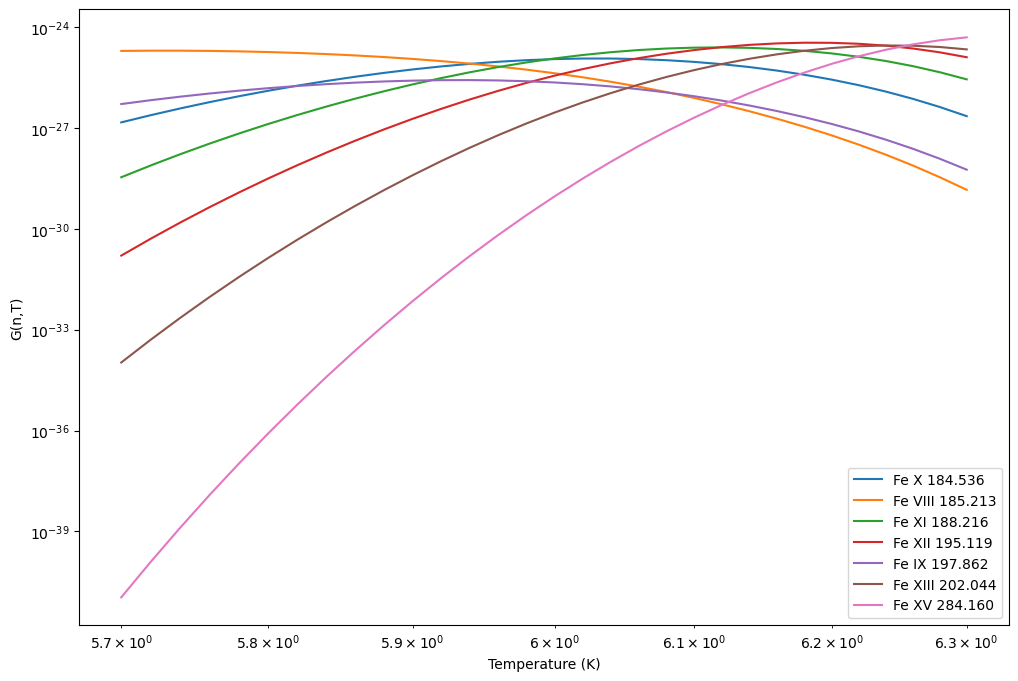

In [6]:
## Plot the contribution functions 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
for i,gg in enumerate(gofnt_s):
    ax.loglog(np.log10(temp),gg,label=int_maps_new[i].meta['line_id'])
ax.set_xlabel('Temperature (K)') 
ax.set_ylabel('G(n,T)')
ax.legend()   

##### Prepare the DEM inputs 

In [7]:

## dn_in : in energy units (nx*ny*nlines array)
dn_in = np.array(int_pix) 
# If I am consistent in the units of Intensities and Contribution function it shouldn't matter
# if the units are in photon counts or in energy units, I think so!


## edn_in : Error in the intensities (nx*ny*nlines)
# Here I can use a manual selection of the error as a percentage of the observed values 
# or the original error (see below, comment/uncomment as necessary)
error_perc = 10
err_int_data = (error_perc * np.array(int_pix))/100.
edn_in = err_int_data
## Original error
# orig_err_int_data = []
# for intmap in int_maps:
#     orig_err_int_data.append(intmap.uncertainty.array[iy,ix])
# edn_in = orig_err_int_data


## tresp : The temperature response matrix (n_tresp*nlines) (i.e. G(n,T))
nt = len(gofnt_s[0])
nf = len(gofnt_s) 
trmatrix = np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i] = gofnt_s[i] 
    
    
## tresp_logt: 
tresp_logt = np.log10(temp)


## temps : The DEM 'target' temperatures
mint = 5.3#5.7 #5.7
maxt = 6.5#6.3 #7.2
# the tresp resolution is 0.05 logt so cant use a resolution finer than that
dlogt = 0.07#.042#0.05
temps = 10**np.arange(mint,maxt+dlogt,dlogt)


##### Run the DEM 
Initializing first a number of inputs, that are used to test different runs

In [8]:

max_iter = 500
l_emd = False
reg_tweak = 2.0
rgt_fact = 1.1

## 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
dem0, edem0, elogt0, chisq0, dn_reg0 = dn2dem(dn_in,edn_in,trmatrix,
                                              tresp_logt,temps,
                                              max_iter=max_iter,l_emd=l_emd,
                                              reg_tweak=reg_tweak,
                                              rgt_fact=rgt_fact)
#  Regularization in EMD [cm^-5] instead of DEM [cm^-5 K^-1] space
dem0a,edem0a,elogt0a,chisq0a,dn_reg0a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,
                                             temps,emd_int=True,
                                             max_iter=max_iter,l_emd=l_emd,
                                             reg_tweak=reg_tweak,
                                             rgt_fact=rgt_fact)

## 2. EMloci - reg runs once, works out weight for constraint matrix as min of 
# EM Loci, then regs with that. If some of your filters have a sharper T 
# response (lines or X-ray obs) might be useful to try.
# gloci=1 -> uses the min of EM loci curves to weight L
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,
                                        gloci=1, max_iter=max_iter,l_emd=l_emd,
                                        reg_tweak=reg_tweak,rgt_fact=rgt_fact)
dem1a,edem1a,elogt1a,chisq1a,dn_reg1a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,
                                             temps,gloci=1,emd_int=True,
                                             max_iter=max_iter,l_emd=l_emd,
                                             reg_tweak=reg_tweak,
                                             rgt_fact=rgt_fact)

Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?


Calculate again the DEM, using user-defined weights for the constraint matrix.
The construction of this is based on the DEM of Chianti for a Coronal Hole.

In [9]:
import os 
import ChiantiPy.tools.io as chio 

## Get the Chianti DEMs
demDir = os.path.join(os.environ['XUVTOP'], 'dem')
demList = os.listdir(demDir) 
# Coronal hole 
ch_dem_CH = chio.demRead(demList[8])
# Quite Sun
ch_dem_QS = chio.demRead(demList[3])

dem_mod = np.interp(temp,ch_dem_CH['temperature'],ch_dem_CH['dem'])

In [10]:
## Run the DEM with the 3rd methods (user-defined)

mlogt1=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])  

# demwght0 = dem_mod
demwght0 = 10**np.interp(mlogt1,tresp_logt,np.log10(dem_mod))

dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,
                                        temps,dem_norm0=demwght0/max(demwght0)
                                        ,max_iter=max_iter,l_emd=l_emd,
                                        reg_tweak=reg_tweak,
                                        rgt_fact=rgt_fact)
#better with l_emd=False 
dem2a,edem2a,elogt2a,chisq2a,dn_reg2a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,
                                             temps,dem_norm0=demwght0/max(demwght0),
                                             emd_int=True,
                                             max_iter=max_iter,l_emd=l_emd,
                                             reg_tweak=reg_tweak,
                                             rgt_fact=rgt_fact)

#### Plot the DEM 
I use a number of boolean keywords to adjust the plot as I am doing different tests. Most of them can be neglected for a simple display of the DEM.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


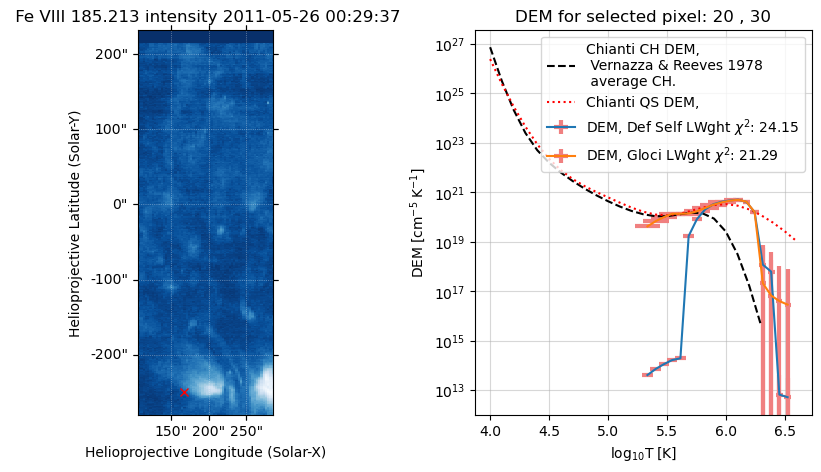

In [11]:
temps = 10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])  #TODO figure out this better
    
# Flags to select what I will include in my plot 
plot_y_in_log = True#False
plot_ch_dem_CH = True#False
plot_ch_dem_QS = True#False
plot_EMD_res = False
plot_userdef_dem = False
plot_def_dem = True  #default option
plot_gloci_dem = True
plot_EM_loci_curves = False

fig = plt.figure(figsize=[10,5])
plot_grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.3)

intmap  = int_maps_new[1]
ax = fig.add_subplot(plot_grid[0,0],projection=intmap)
intmap.plot(axes=ax)
ax.plot(ix,iy,'rx')


# ax.plot(mlogt,dem0[a,b,:])
ax2 = fig.add_subplot(plot_grid[0,1])

# 1
if plot_def_dem:
    ax2.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,
                 ecolor='lightcoral', elinewidth=3, capsize=0,
                 label=r"DEM, Def Self LWght $\chi^2$: %0.2f"%chisq0)

# 2
if plot_gloci_dem:
    ax2.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,
                 ecolor='lightcoral', elinewidth=3, capsize=0,
                 label=r"DEM, Gloci LWght $\chi^2$: %0.2f"%chisq1)

# 3 
if plot_userdef_dem:
    ax2.errorbar(mlogt1,dem2,xerr=elogt2,yerr=edem2,
                 ecolor='lightcoral', elinewidth=3, capsize=0,
                 label=r"DEM, UserDef LWght $\chi^2$: %0.2f"%chisq2)
    
if plot_EMD_res:
    ax2.errorbar(mlogt,dem0a,xerr=elogt0a,yerr=edem0a,
                 ecolor='lightcoral', elinewidth=3, capsize=0,
                 label=r"L_EMD, Def Self LWght $\chi^2$: %0.2f"%chisq0a)
    ax2.errorbar(mlogt,dem1a,xerr=elogt1a,yerr=edem1a,
                 ecolor='lightcoral', elinewidth=3, capsize=0,
                 label=r"L_EMD, Gloci LWght $\chi^2$: %0.2f"%chisq1a)

# Chianti DEM
if plot_ch_dem_CH:
    ax2.plot(np.log10(ch_dem_CH['temperature']),ch_dem_CH['dem'],'k',
             ls='dashed',
             label='Chianti CH DEM,\n Vernazza & Reeves 1978 \n average CH.')
if plot_ch_dem_QS:
    ax2.plot(np.log10(ch_dem_QS['temperature']),ch_dem_QS['dem'],'r',
             ls='dotted',
             label='Chianti QS DEM,')
    
ax2.grid(alpha=0.5)
ax2.set_title('DEM for selected pixel: %.f , %.f'%(ix,iy))
ax2.set_xlabel('$\mathrm{\log_{10}T\;[K]}$')
ax2.set_ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
if plot_y_in_log:
    ax2.set_yscale('log')

em_loci_curves = []
if plot_EM_loci_curves:
    for i,gg in enumerate(gofnt_s):
        em_loci = (dn_in[i]/gg)/10**4.  
        #em_loci is in cm^-1 -> to go to cm^-5, I divide by 10**4 (need to verify if this is correct)
        em_loci_curves.append(em_loci)
        ax2.plot(np.log10(temp),em_loci,'k--')
        
plt.legend()

##### Check the modeled intensities


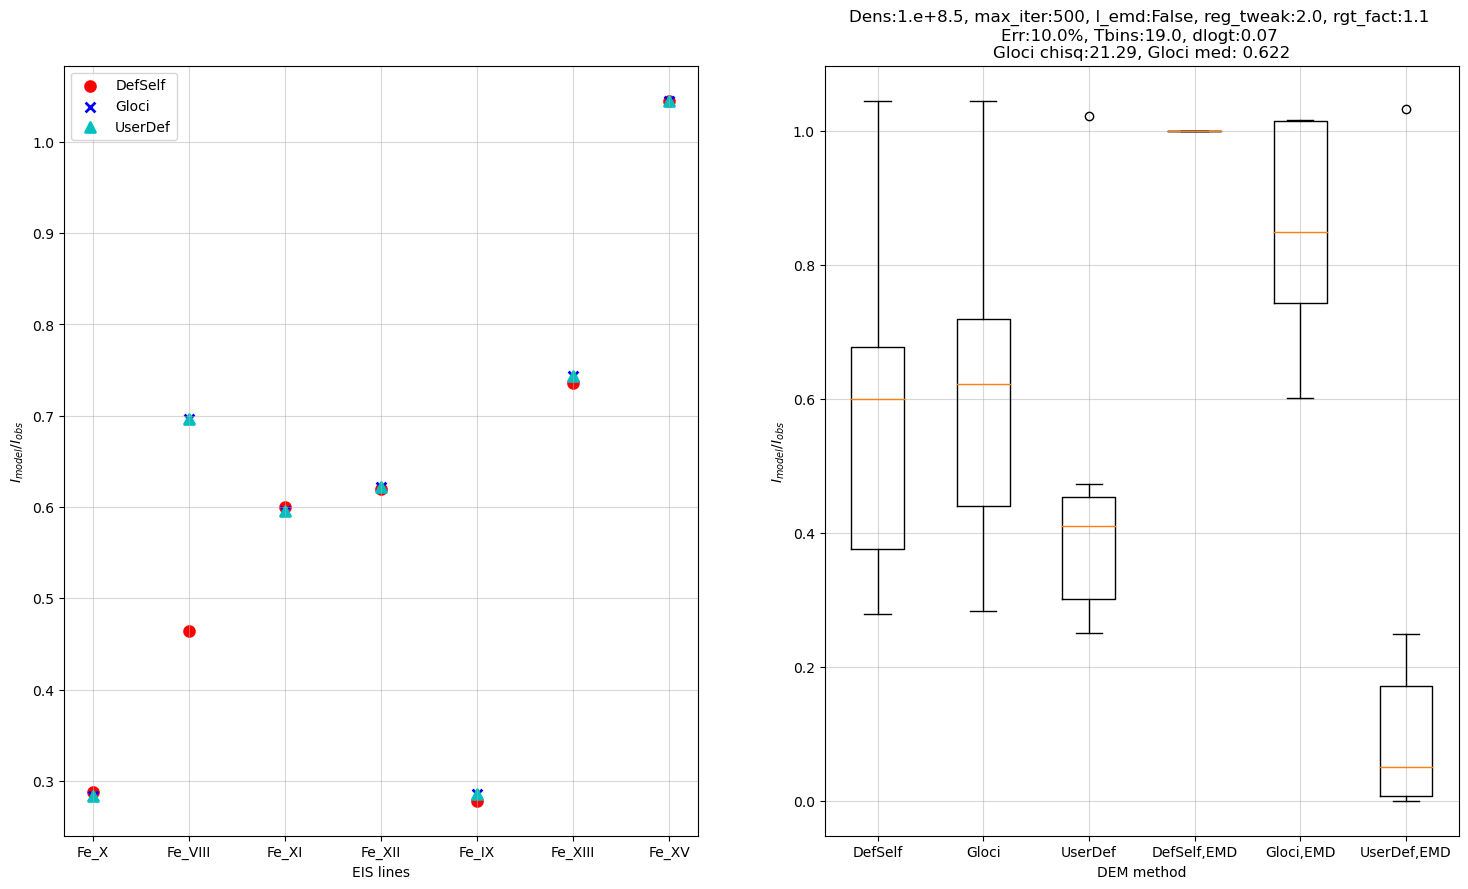

In [12]:

# Compute the ratio of modeled vs observed intensity
ratio0 = dn_reg0/dn_in 
ratio1 = dn_reg1/dn_in 
ratio2 = dn_reg2/dn_in 
ratio0a = dn_reg0a/dn_in 
ratio1a = dn_reg1a/dn_in 
ratio2a = dn_reg2a/dn_in 
ratio_list2 = [ratio0,ratio1,ratio2,ratio0a,ratio1a,ratio2a]
methods_list2 = ['DefSelf','Gloci','UserDef','DefSelf,EMD','Gloci,EMD','UserDef,EMD']
lines_list = []
for intmap in int_maps_new:
    ion_name = intmap.meta['line_id'].split()[0:2]
    lines_list.append('_'.join(ion_name))


fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(121)

xx = np.arange(start=1,stop=8)
ax.scatter(xx,dn_reg0/dn_in,marker='o',color='red',s=50,lw=2,label='DefSelf')
ax.scatter(xx,dn_reg1/dn_in,marker='x',color='blue',s=50,lw=2,label='Gloci')
ax.scatter(xx,dn_reg1/dn_in,marker='^',color='c',s=50,lw=2,label='UserDef')
## Optional, as the plot can become too crowded 
# ax.scatter(xx,dn_reg0a/dn_in,marker='+',color='red',s=50,lw=2,label='DefSelf, EMD')
# ax.scatter(xx,dn_reg1a/dn_in,marker='+',color='blue',s=50,lw=2,label='Gloci, EMD')
# ax.scatter(xx,dn_reg2a/dn_in,marker='+',color='c',s=50,lw=2,label='UserDef, EMD')
ax.set_ylabel(r'$I_{model}/I_{obs}$')
ax.set_xlabel('EIS lines')
ax.set_xticks(np.arange(start=1,stop=8))
ax.set_xticklabels(lines_list)
ax.grid(alpha=0.5)
ax.legend()

## Box plots to have a quantitative view of how well each method performs 
ax1 = fig.add_subplot(122)
ax1.boxplot(ratio_list2)
ax1.set_ylabel(r'$I_{model}/I_{obs}$')
ax1.set_xlabel('DEM method')
ax1.set_xticklabels(methods_list2)
ax1.set_title('Dens:1.e+%.1f, max_iter:%.f, l_emd:%s, reg_tweak:%.1f, rgt_fact:%0.1f \n' 
             %(np.log10(dens),max_iter,l_emd,reg_tweak,rgt_fact)
             +'Err:%.1f%%, Tbins:%0.1f, dlogt:%.2f \n'
             %(error_perc,temps.shape[0],dlogt)
             +'Gloci chisq:%.2f, Gloci med: %.3f'%(chisq1,np.median(ratio1)))

ax1.grid(alpha=0.5)
# ax1.legend()
